# Man is to Computer Programmer as Woman is to Homemaker? Debiasing Word Embeddings

This notebook reviews a paper from 2016 by the [New England Microsoft Research Team and Boston University](https://arxiv.org/pdf/1607.06520.pdf) titled _Man is to Computer Programmer as Woman is to Homemaker? Debiasing Word Embeddings_. From the title alone, you can gather that the problem they were trying to solve was to try and remove unnecessary gender typing from word embeddings, that are unfortunate side-effects to unsupervised learning. In this notebook, you'll be able to play around with some of the popular word embedding implementations, and see how the problem outlined in the paper can manifest itself.

---

## Word embeddings

To start with, we'll give a brief overview of what word embeddings are. If we want to automate some kind of analysis, we have to represent whatever data we are working with into a format that machines can operate on. Whether that be language translation, drug discovery, or self-driving cars, we have to be able to compress the data into some compact vector format that captures all of the relevant information needed to perform the analysis/make decisions. 

As an example, translating from English to French by machine learning would need the word "library" to be translated into a vector of bits, processed by some kind of model (even linear regression!), which returns the analogous vector in "computer French", which could then be looked up in a dictionary (literally) to give the equivalent word in French.

```
# english to french translation
"library" -> [0, 1, 0...] -> model -> [1, 0, 1...] -> "bibliothèque"
```

The process of going from word to vector is referred to as _encoding_; the vector itself is also called an encoding and sometimes embedding interchangably. Word embeddings are a method of turning words—as strings—into set-length vectors of features that can subsequently be used for machine analysis. The idea behind these representations is to allow comparisons of words in a continuous space, for example:

$$ \mathrm{King - Queen = Man - Woman} $$

with the right kind of embedding, you would be able to perform logical operations on text data that ultimately gives us applications like machine translation models sentiment classification. The tricky thing is to learn useful embeddings that can span extremely large corpuses (the dictionary of words), and maintain the same degree of usefulness even with words outside the training corpus. The advantage of machine learning is not needing to hand-code all of these heuristics into your encoding scheme. The idea is to let some algorithm develop its _own heuristic_, either in a supervised or unsupervised way. In the former, you will have specific examples to train the model against; in the above example, maybe a regression model that learns to encode words based on their distances from other words (i.e. "elephant" vs. "dog" vs. "car"). In the latter, the model develops its own heuristics (hence unsupervised) based on whatever is necessary to perform some task. The unsupervised case is attractive both because you don't need specific labeled examples, and also because the language model will devise its own heuristics: there will be edge cases I as a human will have missed that the model has a chance of covering - providing there are enough examples of it).

## Unsupervised encoding

So how would you train a model in an unsupervised way, that manages to capture all the nuances about language, such as context, meaning, syntax, and grammar? The most straightforward way is to just give a model sentences to reproduce: given a sentence, encode each word into vectors, and use the same vectors to recreate the sentence accurately. In this way, a model will self-penalize when the wrong word is used in the wrong place, and by updating how the vectors are generated, you eventually end up with a model that maps words into vectors that recall the right word in the right place (hopefully most of the time).

One of the first really successful attempts at this was by [Bengio _et al._ in 2003](http://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf) showed that a small neural network could actually learn embeddings in an unsupervised fashion:

![nnlm](bengio_nnlm.png)

The neural network learns an embedding (the earlier layers) by predicting the correct word, given a context. 

The problem with the earlier approach is the computational inefficiency of the output softmax layer ($\exp(w_t)/\sum \exp(w_t)$) and its set dimensionality: the embedding diversity only grows with the context and word diversity, and if it's set at 10,000 words (or any number for that matter) this sets a roof to the level of complexity we can reach.

## Word2Vec

A more modern approach, and now one of the most widely used methods of generating embeddings is the `word2vec` technique developed by Mikolov _et al._ [(paper)](https://arxiv.org/abs/1301.3781).  In summary, a small neural network is taught to transform words into a 300-dimensional embedding based on a 1.6 billion word dataset; a year or so later they trained on a 100 billion word dataset. The architecture that performed best of two was the continuous-bag-of-words (CBOW), which was trained to predict the most likely word, given a context (e.g. Jane visits _blank_ in September). Over training, the network learns to produce embeddings that encode how words are used in various contexts, represented within the 300-dimensional vector. If you're wondering why the choice of a 300-dimensional embedding, the authors tested larger embeddings, and did not see huge improvements—if you think in terms of basis vectors, convergence of this basis becomes logarithmic near this size for this architecture. 

![cbow](cbow-skipgram.png)

You can play around with `word2vec` below, by loading pre-trained models/corpuses. For more information about these datasets, see [this link](https://github.com/RaRe-Technologies/gensim-data). A very lightweight model is "text8", which is a couple of megabytes. One of the largest, and the one under scrutiny is the model trained on the Google News' feed, usually referred to as `w2vnews`. The interesting effect of training on various sources is the semanticity that these models learn to produce in embeddings: writing style is "absorbed" into the model, and so the context/quality of embeddings from "text8" is significantly different from `w2vnews`; the former is more "academic" while the latter reflects writing in modern society more.

In [3]:
!pip install gensim

In [33]:
import numpy as np
from matplotlib import pyplot as plt
from gensim.models import Word2Vec
import gensim.downloader as api

In [7]:
# This can get loud, so only run if you're interested in trying out word2vec!
RUN = True

if RUN:
    # Text8 is the first 100,000,000 bytes in Wikipedia
    corpus = api.load("text8")
    model = Word2Vec(corpus)

"text8" is trained on 17 million words:

In [8]:
model.corpus_total_words

17005207

You can retrieve embeddings by using the `model.wv.get_vector` method:

In [38]:
king = model.wv.get_vector("king")
man = model.wv.get_vector("man")

The Word2Vec interface gives access to a bunch of convenience functions too, like looking up the corpus based on cosine similarity:

In [41]:
model.wv.similar_by_vector(king - man)

[('king', 0.7000098824501038),
 ('dukes', 0.5468707084655762),
 ('vii', 0.5334069132804871),
 ('kings', 0.5269961357116699),
 ('sultan', 0.5252265930175781),
 ('umayyad', 0.5200234055519104),
 ('iii', 0.5178303718566895),
 ('aragon', 0.5035035610198975),
 ('antiochus', 0.49747395515441895),
 ('princes', 0.49325495958328247)]

In [44]:
model.wv.cosine_similarities(king - man, [model.wv.get_vector("queen")])

array([0.4165773], dtype=float32)

Based on this example, it's obvious that getting useful embeddings is a difficult task: the embeddings depend strongly on context, and based on 17 million words in Wikipedia, this is still not enough get embeddings for such a high level concept.

You can either train your own `word2vec` model on your own corpus, or use a pre-trained model (e.g. [here](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing), it's 1.5GB though!). Applications-wise you could use transfer learning from one of these large pre-trained models for your own application (for example academic translation), or distillation learning to get a model working.

---

## The problem with word embeddings

Since these language models are based on written text, one issue that became apparent to the authors of the [NIPS paper](https://papers.nips.cc/paper/6228-man-is-to-computer-programmer-as-woman-is-to-homemaker-debiasing-word-embeddings.pdf) is an unintended side-effect where these embeddings learn gender biases. The problem itself extends outside of gender, where there is just an inherent, underlying bias towards particular contexts that are not intentional. This is particularly a problem for gender when these embeddings are used for real world applications that can have profound effect on peoples' lives, such as resume scanners and review/report generation. This direct quote from the paper:

> However, none of these papers have recognized how blatantly sexist the embeddings are and hence risk introducing biases of various types into real-world systems.

This depends somewhat strongly on the embedding you use, although the authors contend that it's not just Google's large news model.

Based on the idea behind `word2vec`, the unsupervised learning forces the model to produce embeddings based on contexts it has seen. While the focus of the paper is on the effect this has on embeddings, it probably is a better reflection on how society writes news. 

To demonstrate, we're first going to try and extract the "gender" aspect of the embedding. One way that comes to mind is simply to take opposite gender words, and take the difference of these embeddings; for example, $\mathrm{man} - \mathrm{woman}$—the concept of gender should be the dominant residual context (if the embedding has been generated well).

In [4]:
# This step actually downloads the w2vnews model; 
# if you don't want to download 1.6 GB don't run this
RUN = False

if RUN:
    w2vnews = api.load("word2vec-google-news-300")

In [5]:
g = w2vnews.get_vector("woman") - w2vnews.get_vector("man")

The residual vector, $g$, should have the concept of gender encoded in it.

In [6]:
g.size

300

To test this out, you can loop over a set of common names that have gender encoded:

In [54]:
similarities = list()
names = ["john", "jesse", "mary", "jessie", "elton", "kelvin", "katie", "charles"]
for name in names:
    name_vec = w2vnews.get_vector(name)
    similarity = w2vnews.cosine_similarities(name_vec, [g])
    similarities.append(similarity)
    print(name, w2vnews.cosine_similarities(name_vec, [g]))

john [-0.03143504]
jesse [-0.03190297]
mary [0.09950283]
jessie [0.01639201]
elton [0.01321754]
kelvin [-0.07067004]
katie [0.12954304]
charles [-0.06644631]


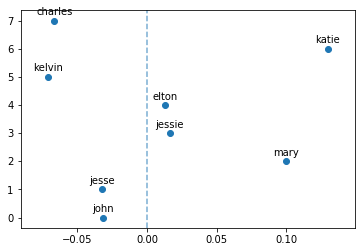

In [89]:
fig, ax = plt.subplots(figsize=(6,4))

Y = np.arange(len(similarities))

ax.scatter(similarities, Y)
for x, y, name in zip(similarities, Y, names):
    ax.text(x, y + 0.2, name, horizontalalignment="center")
ax.axvline(0., ls="--", alpha=0.6)

What you see here is predominantly male names are negative, while female names are positive (except for Elton?). This operation is basically showing you which side of an axis (the "gender" axis) you are on with a given word. With names and other gender-appropriate/specific words this is fine, but when you start applying it to other word embeddings it becomes a problem:

In [82]:
professions = ["homemaker", "programmer", "doctor", "nurse", "receptionist", "captain", "boss"]
for profession in professions:
    name_vec = w2vnews.get_vector(profession)
    print(profession,  w2vnews.cosine_similarities(name_vec, [g]))

homemaker [0.33099553]
programmer [-0.03050756]
doctor [0.16264015]
nurse [0.33768806]
receptionist [0.32569164]
captain [-0.13851051]
boss [-0.13585725]


Interestingly, the cosine similarities for these words are much more strongly gendered than names. The problem you can see manifests itself in a few words like boss, captain that are strongly biased towards male, whereas nurse and receptionist are female.

## Solution: project out the gender embedding

The key here to simply calculate a vector of $g$ that reliably encodes the gender dimension of our problem, and simply use this vector to project out any words that do not have a gender appropriate component; for example, names like John and Mary are appropriately gender-specific, and so is grandma and brother. Conversely, words like model, shopping, and football should nominally have no gender component, although there are some gray areas like "widwife"...

The bulk of the paper works out various methods of removing gender bias that are latent in these word embeddings. One way was to utilize vector math to project out the gender dimension from words that should not have significant bias, and the research was into defining a vector, $g$, that embodies the gender component of a 300-dimensional vector best.

![basisfigure](fig2.png)

## Projection operator

Obtain $\vec{v_\mathrm{gender}}$ as the gender component of $\vec{v}$, the word vector of interest, by projecting it onto the "gender" axis (I use quotations here because it's probably not a purely gender dimension, but a mixture of different features closely associated with gender).

$$ \vec{v_\mathrm{gender}} = \frac{\vec{v} \cdot \vec{g}}{\vert \vert \vec{g} \vert \vert^2_2} $$ 

The "debiased" vector, $\vec{v_\mathrm{debias}}$, is given by subtracting out the gender part of the embedding,

$$\vec{v_\mathrm{debias}} = \vec{v} - \vec{v_\mathrm{gender}} $$

In [60]:
target_word = "philosopher"
target_vector = w2vnews.get_vector(target_word)

In [62]:
# Similarity before we project out gender
unprojected_similarity = w2vnews.cosine_similarities(target_vector, [g])

In [79]:
def project_ab(a: np.ndarray, b: np.ndarray):
    """
    Project vector a onto vector b; takes two 1D NumPy arrays as input.
    """
    return np.dot(a, b) / np.linalg.norm(b, ord=2)**2.


def debias_word(wordvec: np.ndarray, gender_embedding: np.ndarray):
    """
    Subtract out the gender dimension from the embedding. Uses a reference
    gender embedding vector to perform the projection.
    """
    return wordvec - project_ab(wordvec, gender_embedding)

In [80]:
debiased = debias_word(target_vector, g)

In [83]:
debiased_professions = [debias_word(w2vnews.get_vector(profession), g) for profession in professions]

In [88]:
for profession, vec in zip(professions, debiased_professions):
    print(profession, w2vnews.cosine_similarities(vec, [g]))

homemaker [0.08230869]
programmer [-0.02580311]
doctor [0.0722914]
nurse [0.08140509]
receptionist [0.08034401]
captain [-0.06835929]
boss [-0.06978016]


Compare with the values above, and you'll see that while the projection is not complete (it won't go to zero due to mixing in the basis vector), we have largely elminated the $g$ contamination in our word embedding. As to whether or not this adversely affects performance of these word embeddings, the authors showed that this projection does not change the performance of word analogies and other uses significantly.

# Conclusions

Due to the nature of unsupervised learning of word embeddings, you have these unfortunate side-effects that we should be cognizant about: outside of gender, you can imagine that there are similar biases towards other concepts that may affect production models. Beyond word embeddings, you can also imagine this can happen to any sort of autoencoder model, which learns to reproduce data but not necessarily always the way you want it to; we should be cognizant of this when applying these kinds of models to problems, and it pays to understand how your encoding/embedding is formed by visualizing and testing it.


### Further reading

[GLoVE model](https://nlp.stanford.edu/pubs/glove.pdf), a more recent model for word embeddings.

[Grad-CAM](http://openaccess.thecvf.com/content_iccv_2017/html/Selvaraju_Grad-CAM_Visual_Explanations_ICCV_2017_paper.html), a visualization technique for convolutional neural networks.

[Men also like shopping: Reducing gender bias amplification using corpus-level constraints](https://arxiv.org/abs/1707.09457), a more recent paper on removing gender bias from word embeddings.

[Using adverserial learning to mitigate stereotyping](https://dl.acm.org/doi/abs/10.1145/3278721.3278779).